##  Задача 1

$Y = \theta + \epsilon$, $E\epsilon =0$ <br>
$A\theta = 0$

Пусть $\lambda = (\lambda_1, \lambda_2, ...., \lambda_n)^T$

Распишем лагранжиан: $${L}(\lambda) = ||Y - \theta||^2 + \lambda^T A \theta = (Y- \theta)^T(Y - \theta) + \lambda^T A \theta = Y^T Y - Y^T \theta - \theta^T Y + \theta^T \theta + \lambda^T A \theta = $$
$$ = |Y^T \theta\; и \;\theta^T Y \;- \;числа \Rightarrow Y^T \theta = \theta^T Y| = Y^T Y - 2 Y^T \theta + \theta^T \theta + \lambda^T A \theta $$

$$\frac{d{L}(\lambda)}{d\lambda} = A\theta = 0$$
$$\frac{d{L}(\lambda)}{d\theta} = -2Y^T + 2\theta^T + \lambda^T A$$
$$\Rightarrow \theta^T = Y^T - \frac{1}{2} \lambda^T A \Rightarrow \theta = Y - \frac{1}{2} A^T \lambda$$
Домножим полученное на A:
$$0 = A\theta = AY - \frac{1}{2} A A^T \lambda$$
$$\Rightarrow A A^T \lambda = 2 AY \Rightarrow \lambda = 2(A A^T)^{-1} AY$$
Подставим полученное $\lambda$ в выражение для $\theta$ и получим:
$$\theta^* = Y - \frac{1}{2} A^T \lambda = Y - \frac{1}{2} A^T (2(AA^T)^{-1}AY) = (I_n - A^T (A A^T)^{-1} A) Y$$

## Задача 2

In [169]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm
import scipy.stats as sps
from scipy.stats import pearsonr, t

from scipy.stats import f
import seaborn as sns
import copy
import matplotlib.pyplot as plt

%matplotlib inline

**Файл со страницы МСПС (не содержит признаков в тесте)**

Скачаем данные. И сразу же запомним номера тестовых и тренировочных объектов

In [2]:
data = []
test_numbers = []
train_numbers = []
with open('Prostate_train.txt', 'r') as file:
    raw_data = file.read().split('\n')
    count_data = len(raw_data)
    for i, line in enumerate(raw_data):
        data_i = np.array(line.split('\t')[1:])
        if '' not in data_i and len(data_i) != 0:
            data.append(data_i)
            if i != 0:
                train_numbers.append(i + 1)
        else:
            test_numbers.append(i + 1)
            

for i, line in enumerate(data[1:]):
    if line[-1] == 'T':
        data[i+1][-1] = 1
    else:
        data[i+1][-1] = 0
        
data = np.array(data)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


Если посмотреть на данные, можно заметить, что вся тренировочная выборка состоит из обьектов, для которых значения всех признаков известны, а тестовая из обьектов, на которых ни одно значение признака неизвестно. Поэтому искать какие-либо зависимости целевой переменной от значений признака для предсказания целевой переменной на тестовой выборке не имеет смысла. 
Однако можно заметить, что у нас есть id, поэтому будем обучаться на нем. Кроме того можно заметить, что целефая переменная возрастает по id, то есть они очень коррелированы, что хорошо.

In [9]:
test_numbers = np.array(test_numbers) - 1
train_numbers = np.array(train_numbers) - 1

In [42]:
y_train = np.array(list(map(float, data[1:,-2])))
model = LinearRegression()
model.fit(train_numbers[:,np.newaxis], y_train)
all_predictions = model.predict(np.arange(1, max(test_numbers[-1], train_numbers[-1]) + 1)[:,np.newaxis])

In [43]:
np.sqrt(mean_squared_error(all_predictions[train_numbers - 1], y_train))

0.32742228006117297

**Файл с kaggle**

In [828]:
data = pd.read_csv('Prostate_train.csv')
data.head()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


Разбиваем на тест и обучение

In [829]:
ind_test = np.where(data.isnull().values[:,-1])
ind_train = np.where(data.isnull().values[:,-1] == False)
train_data = data.iloc[ind_train]
test_data = data.iloc[ind_test]

Обучим лин. регрессию на всех признаках

In [801]:
model = LinearRegression()
model.fit(np.array(train_data)[:,:-1], np.array(train_data)[:,-1])
pred = model.predict(np.array(train_data)[:,:-1])
np.sqrt(mean_squared_error(pred, np.array(train_data)[:,-1]))

0.30075116444279393

Может можно сделать лучше? Посмотрим на графики

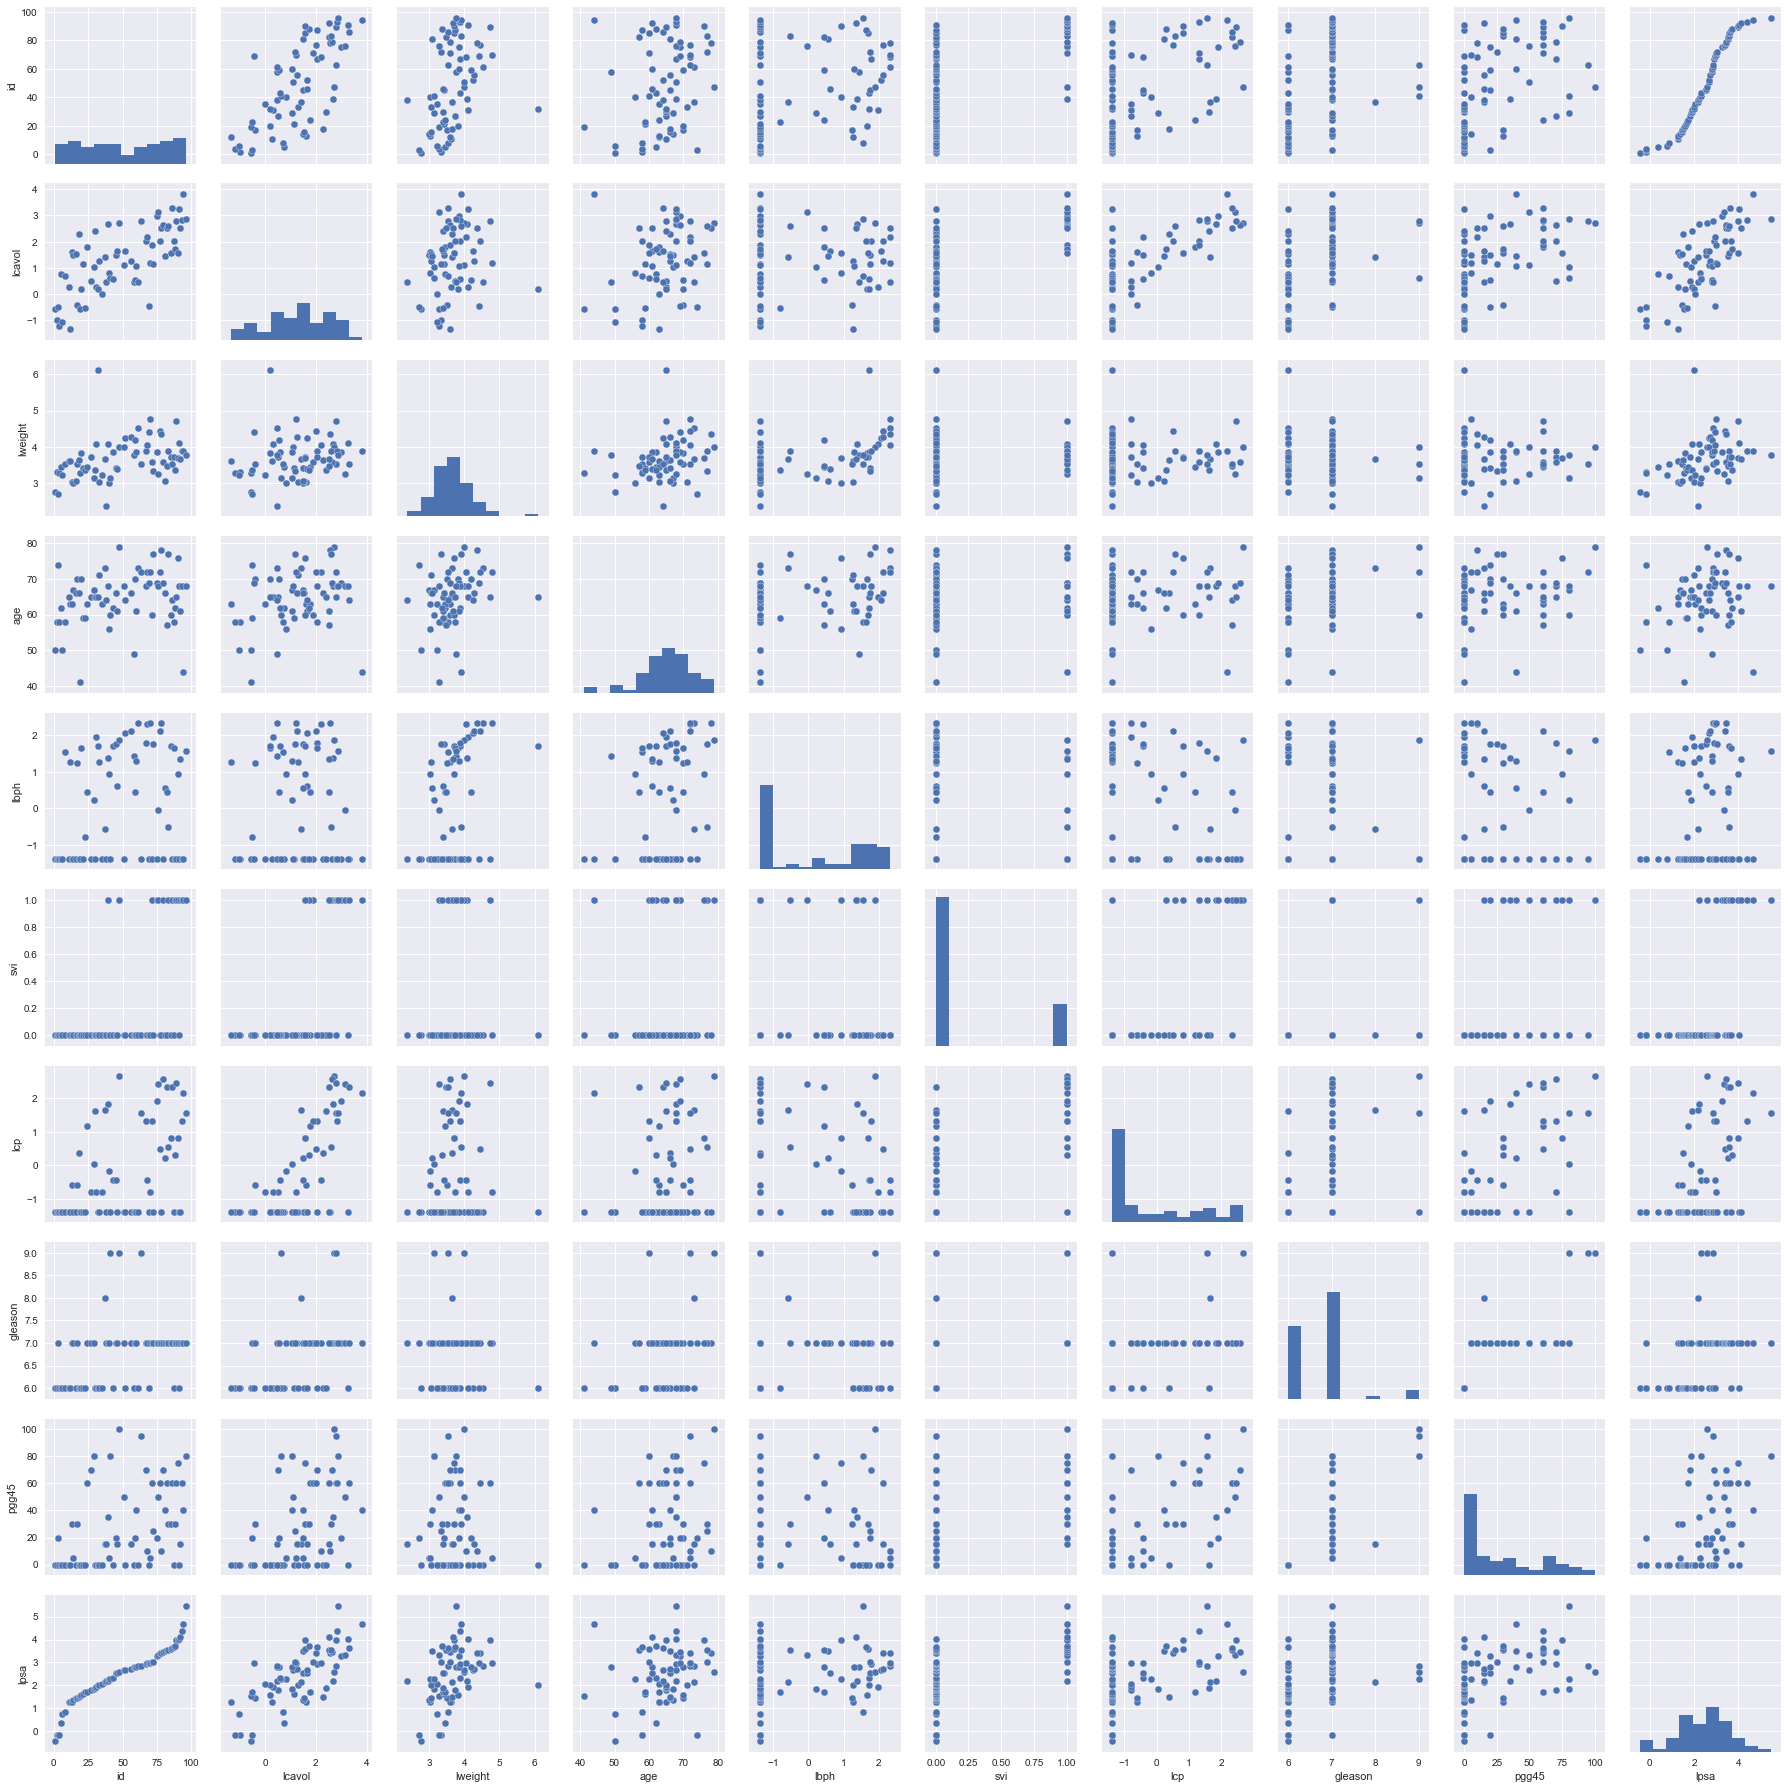

In [803]:
sns.pairplot(train_data)

Видим сильную зависимость целевой переменной от id, причем зависимость похожа на кубическую. Поэтому добавим $id^2, id^3$

In [830]:
data['id_2'] = np.array(data['id']) **2
data['id_3'] = np.array(data['id']) **3

In [807]:
data.head()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,id_2,id_3
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,1,1
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,4,8
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,9,27
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,16,64
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,25,125


In [831]:
ind_test = np.where(data.isnull().values[:,-3])
ind_train = np.where(data.isnull().values[:,-3] == False)
train_data = data.iloc[ind_train]
test_data = data.iloc[ind_test]

X_train = train_data.drop('lpsa', axis=1)
y_train = train_data.lpsa

model = LinearRegression()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
np.sqrt(mean_squared_error(pred_train, y_train))

0.16304477932407524

Видим, что стало гораздо лучше. Отправляем предсказания

In [835]:
sample = pd.read_csv('Prostate_sample.csv')
X = data.drop('lpsa', axis=1)
all_predictions = model.predict(X)
sample.lpsa = all_predictions
sample.to_csv('answers_1.csv', index=False)

## Задача 3

In [860]:
data = pd.read_csv('hw9t3_train.csv')

Кодируем категориальные признаки. Такой только один - mood

In [861]:
int_encoder = LabelEncoder()
data['mood'] = int_encoder.fit_transform(data['mood'])

bin_encoder = OneHotEncoder()
category_data = bin_encoder.fit_transform(np.array(data['mood']).reshape(-1, 1)).toarray()

frame_category = pd.DataFrame(category_data, columns=['mood1', 'mood2', 'mood3', 'mood4', 'mood5', 'mood6', 'mood7', 'mood8'])


In [862]:
new_data = pd.concat([data.iloc[:,:-2], frame_category, data.duration], axis=1)
new_data.head()

,id,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,...,sleep,mood1,mood2,mood3,mood4,mood5,mood6,mood7,mood8,duration
0,0,1,1,1,0,0,0,1,1,1,...,3.418333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.851099
1,1,0,1,1,1,1,1,1,1,0,...,3.080932,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
2,2,0,0,1,1,1,1,1,1,0,...,3.229007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.751619
3,3,1,1,1,1,1,1,1,1,1,...,2.513620,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.366979
4,4,0,1,1,1,1,1,0,0,0,...,3.270901,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN


Разобьем данные на тест и обучение

In [863]:
ind_test = np.where(new_data.isnull().values[:,-1])
ind_train = np.where(new_data.isnull().values[:,-1] == False)
train_data = new_data.iloc[ind_train]
test_data = new_data.iloc[ind_test]

Сначала попробуем применить линейную регрессию на всех признаках

In [864]:
model = LinearRegression()

model.fit(np.array(train_data)[:,:-1], np.array(train_data)[:,-1])
pred = model.predict(np.array(train_data)[:,:-1])
print('rmse на train: ', np.sqrt(mean_squared_error(np.array(train_data)[:,-1], pred)))

rmse на train:  1.178197582187648


Многовато, хочется меньше. Посморим на остатки - зависимость остатков от номера объекта и от целевой переменной.

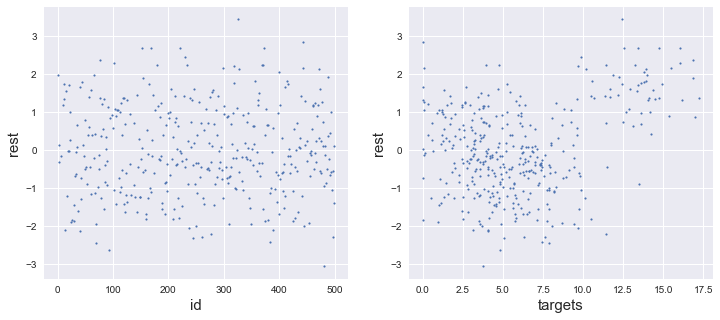

In [865]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.array(train_data.id), np.array(train_data.iloc[:,-1]) - pred, s=3)
plt.xlabel('id', fontsize=15)
plt.ylabel('rest', fontsize=15)

plt.subplot(1, 2, 2)
plt.scatter(np.array(train_data.duration), np.array(train_data.iloc[:,-1]) - pred, s=3)
plt.xlabel('targets', fontsize=15)
plt.ylabel('rest', fontsize=15)

plt.show()

Судя по первому графику автокорреляция остатков небольшая. А вот на втором графике видим разделение на 2 кластера, отсюда можем сделать вывод, что у нас не хватает признаков (или линейная регрессия вообще не очень подходит)

Посмотрим на графики зависимости целевой переменной от остальных.

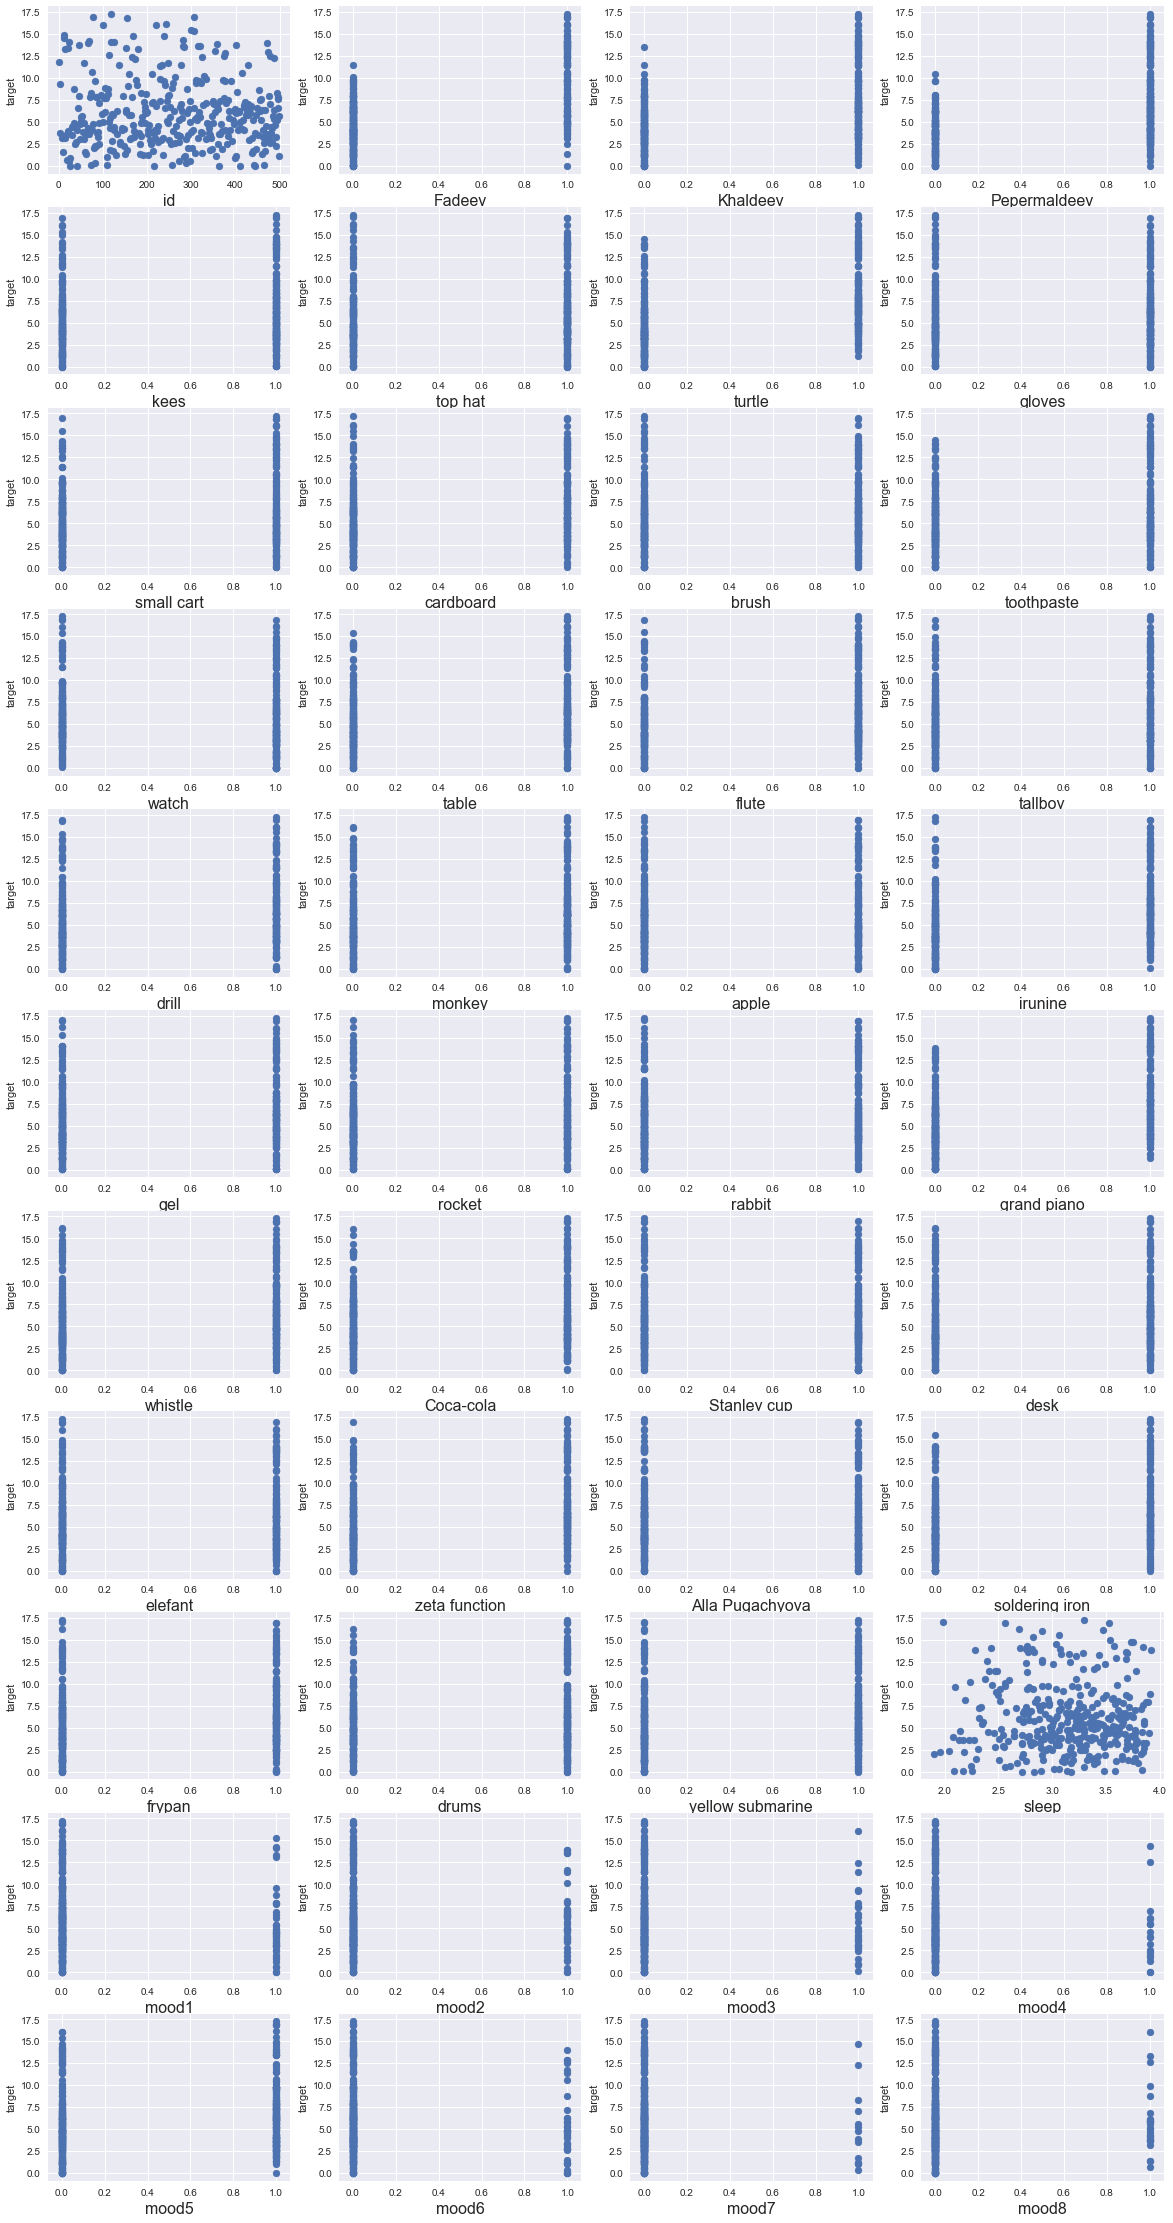

In [282]:
targets = np.array(train_data.iloc[:,-1])
plt.figure(figsize=(20, 40))
for i, name in enumerate(list(train_data.columns)[:-1]):
    plt.subplot(11, 4, i+1)
    feature = np.array(train_data[name])
    plt.scatter(feature, targets)
    plt.xlabel(name, fontsize=16)
    plt.ylabel('target',fontsize=11)
plt.show()

Видим оссобенно сильную зависимость от наличия Фадеева, Калдеева и Перермандеева. То есть при наличии хотя бы какого-то из них в среднеем Фаттахов гуляет значительно больше. Более того, если хотя бы кого-то из друзей нет, то он гуляет в основном не больше 10 единиц времени. Напрашивается вопрос: правда ли, что Фаттахов будет гулять в среднем меньше, если никого из другей нет, и в среднем намного больше, если есть все трое? Для ответа построим еще несколько графиков.

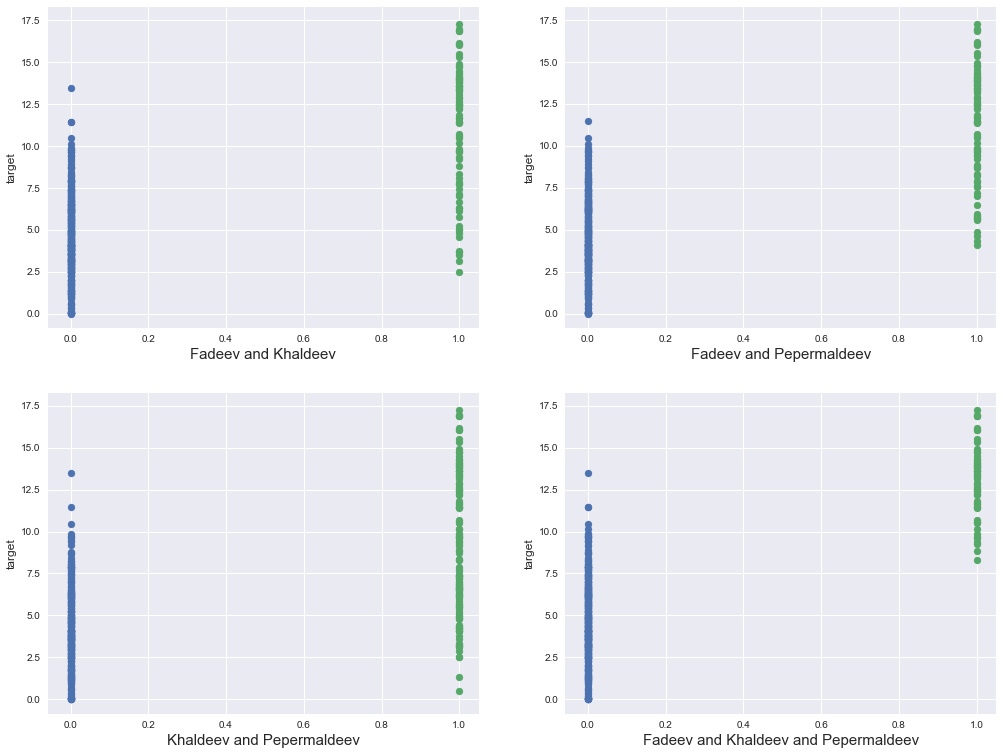

In [866]:
x1 = np.array(train_data.Fadeev)
x2 = np.array(train_data.Khaldeev)
x3 = np.array(train_data.Pepermaldeev)

plt.figure(figsize=(17, 13))

plt.subplot(2, 2, 1)
plt.scatter(np.zeros((x1*x2==0).sum()), targets[x1*x2==0])
plt.scatter(np.ones((x1*x2==1).sum()), targets[x1*x2==1])
plt.ylabel('target', fontsize=12)
plt.xlabel('Fadeev and Khaldeev', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(np.zeros((x1*x3==0).sum()), targets[x1*x3==0])
plt.scatter(np.ones((x1*x3==1).sum()), targets[x1*x3==1])
plt.ylabel('target', fontsize=12)
plt.xlabel('Fadeev and Pepermaldeev', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(np.zeros((x3*x2==0).sum()), targets[x3*x2==0])
plt.scatter(np.ones((x3*x2==1).sum()), targets[x3*x2==1])
plt.ylabel('target', fontsize=12)
plt.xlabel('Khaldeev and Pepermaldeev', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(np.zeros((x1*x3*x2==0).sum()), targets[x1*x3*x2==0])
plt.scatter(np.ones((x1*x3*x2==1).sum()), targets[x1*x3*x2==1])
plt.ylabel('target', fontsize=12)
plt.xlabel('Fadeev and Khaldeev and Pepermaldeev', fontsize=15)
plt.show()

По графикам видим, что это действительно так. Особенно видна зависимость от наличия всех трех друзей. Поэтому добавим эти признаки и построим линейную регрессию на полученных признаках

In [867]:
new_data['Fadeev_Khaldeev'] = np.array(new_data.Fadeev) * np.array(new_data.Khaldeev)
new_data['Fadeev_Pepermaldeev'] = np.array(new_data.Fadeev) * np.array(new_data.Pepermaldeev)
new_data['Khaldeev_Pepermaldeev'] = np.array(new_data.Pepermaldeev) * np.array(new_data.Khaldeev)
new_data['Fadeev_Khaldeev_Pepermaldeev'] = np.array(new_data.Fadeev) * np.array(new_data.Khaldeev) * np.array(new_data.Pepermaldeev)

In [868]:
ind_test = np.where(new_data.isnull().values[:,-5])
ind_train = np.where(new_data.isnull().values[:,-5] == False)
train_data = new_data.iloc[ind_train]
test_data = new_data.iloc[ind_test]

In [869]:
model = LinearRegression()
X_train = train_data.drop('duration', axis=1)
y_train = train_data.duration
X_test = test_data.drop('duration', axis=1)
y_test = test_data.duration

model.fit(np.array(X_train), np.array(y_train))
pred = model.predict(np.array(X_train))
print('rmse на train: ', np.sqrt(mean_squared_error(y_train, pred)))

rmse на train:  0.4655861751853479


Снова посмотрим на остатки.

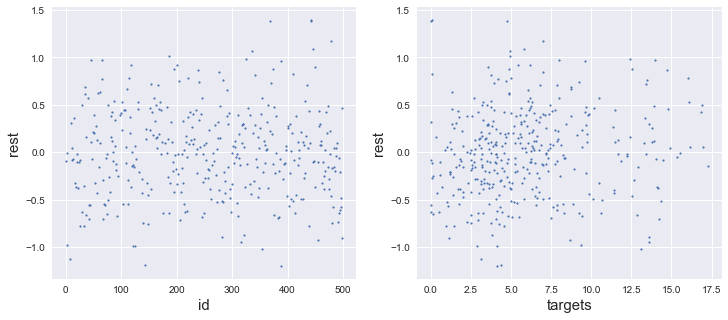

In [870]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.array(train_data.id), np.array(train_data.duration) - pred, s=3)
plt.xlabel('id', fontsize=15)
plt.ylabel('rest', fontsize=15)

plt.subplot(1, 2, 2)
plt.scatter(np.array(train_data.duration), np.array(train_data.duration) - pred, s=3)
plt.xlabel('targets', fontsize=15)
plt.ylabel('rest', fontsize=15)

plt.show()

Сейчас уже все хорошо.

Сохраняем предсказания для всех объектов и если какое-то предсказание получилось меньше 0, поставим маленькое число

In [873]:
X = new_data.drop('duration', axis=1)
all_predictions = model.predict(np.array(X))
all_predictions[all_predictions < 0] = 0.01
sample = pd.read_csv('hw9t3_sample.csv')
sample.duration = all_predictions
sample.to_csv('answers_3.csv', index=False)

# Задача 4

In [884]:
data = pd.read_csv('parkinsons_updrs_train.csv')
data.head()

,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS_train,total_UPDRS_train,id
0,1,72,0,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,...,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,28.199,34.398,1
1,1,72,0,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,...,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,NaN,NaN,2
2,1,72,0,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,...,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,28.695,35.389,3
3,1,72,0,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,...,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,28.905,35.810,4
4,1,72,0,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,...,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,29.187,36.375,5


Разбиваем на train и test

In [885]:
ind_test = np.where(data.isnull().values[:,-2])
ind_train = np.where(data.isnull().values[:,-2] == False)
train_data = data.iloc[ind_train]
test_data = data.iloc[ind_test]

Сначала посмотрим на корреляцию признаков с каждой из целевой переменной

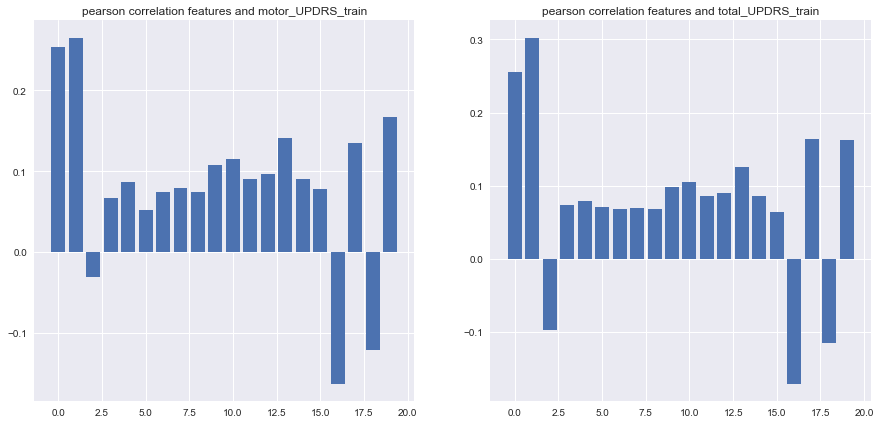

In [889]:
train = np.array(train_data)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.bar(np.arange(train.shape[1] - 3), [pearsonr(train[:,:-3][:, i], train[:,-3])[0] for i in range(train.shape[1] - 3)])
plt.title('pearson correlation features and motor_UPDRS_train')

plt.subplot(1, 2, 2)
plt.bar(np.arange(train.shape[1] - 3), [pearsonr(train[:,:-3][:, i], train[:,-2])[0] for i in range(train.shape[1] - 3)])
plt.title('pearson correlation features and total_UPDRS_train')
plt.show()

Можно заметить, что обе целевых переменных коррелируют с остальными признаками примерно одинаково. Отсюда можно предположить, что и для предсказания двух целевых переменных потребуютя одни и те же признаки.

Также посмотрим на графики зависимости целевых переменных от остальных признаков

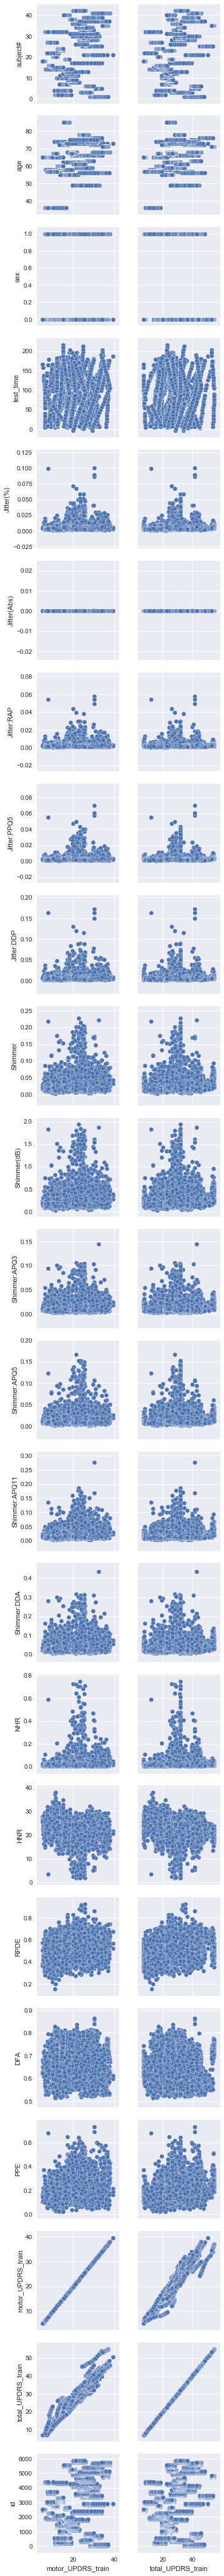

In [890]:
sns.pairplot(train_data, x_vars=['motor_UPDRS_train', 'total_UPDRS_train'], y_vars=list(train_data.columns))

Здесь можем заметить горизонтальные линии на грфике зависимости от subject. Похожий график зависимости от age. Кажется, что при разных значениях subject мы имеем разные модели. 

Сначала посмотрим на подробные результаты линейной регрессии с помощью специального метода

In [891]:
model1 = sm.OLS(np.array(train_data.motor_UPDRS_train), np.array(train_data.drop(['motor_UPDRS_train', 'total_UPDRS_train'], axis=1)))
result = model1.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1885.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:10:53   Log-Likelihood:                -14910.
No. Observations:                4394   AIC:                         2.986e+04
Df Residuals:                    4373   BIC:                         3.000e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.6430      0.310     11.741      0.000       3.035       4.251
x2             0.2478      0.012     20.578      0.000       0.224       0.271
x3            -2.3741      0.278     -8.540      0.000      -2.919      -1.829
x4             0.0154      0.002      7.433      0.000       0.011       0.020
x5          -161.1883    176.055     -0.916      0.360    -506.346     183.969
x6           -5.5e+04   8154.474     -6.745      0.000    -7.1e+04    -3.9e+04
x7         -6.818e+04   4.01e+04     -1.698      0.090   -1.47e+05    1.05e+04
x8          -183.4196    162.811     -1.127      0.260    -502.613     135.773
x9            2.3e+04   1.34e+04      1.719      0.086   -3231.637    4.92e+04
x10           16.4707     56.812      0.290      0.772     -94.910     127.852
x11            1.4601      4.389      0.333      0.739      -7.144      10.065
x12        -2.964e+04   4.04e+04     -0.733      0.464   -1.09e+05    4.96e+04
x13          -29.7128     48.158     -0.617      0.537    -124.126      64.701
x14           37.1901     21.171      1.757      0.079      -4.315      78.695
x15         9859.1147   1.35e+04      0.732      0.465   -1.66e+04    3.63e+04
x16           -0.1704      5.091     -0.033      0.973     -10.151       9.810
x17            0.2273      0.036      6.241      0.000       0.156       0.299
x18            8.3115      1.319      6.302      0.000       5.726      10.897
x19          -19.9085      1.662    -11.977      0.000     -23.167     -16.650
x20           22.4105      2.455      9.130      0.000      17.598      27.223
x21           -0.0252      0.002    -11.151      0.000      -0.030      -0.021
==============================================================================
Omnibus:                      307.095   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.689
Skew:                           0.054   Prob(JB):                     4.13e-24
Kurtosis:                       2.241   Cond. No.                     1.34e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Смотрим на статистику критерия Стьюдента и pvalue. Видим, что некоторые признаки не являются статистически значимыми : x5, x7 -x16. (Однако это говорит лишь о том, что они по отдельности статистически незначимы, а не в совокупности) <br>
Также заметим, что статистика Дарбина—Уотсона достаточно маленькая, поэтому автокорреляция тоже маленькая. Еще посмотрев на статистику Харке-Бера можно заметить, что она большая, а поэтому остатки не похожи на норамальное распределение (о чем также говорит pvalue).


In [352]:
model = LinearRegression()

model.fit(np.array(train_data.drop(['motor_UPDRS_train', 'total_UPDRS_train'], axis=1)), np.array(train_data)[:,-3])
pred = model.predict(np.array(train_data.drop(['motor_UPDRS_train', 'total_UPDRS_train'], axis=1)))
print('rmse на train: ', np.sqrt(mean_squared_error(np.array(train_data)[:,-3], pred)))

rmse на train:  7.107470827253709


rmse очень большой. А что с остатками?

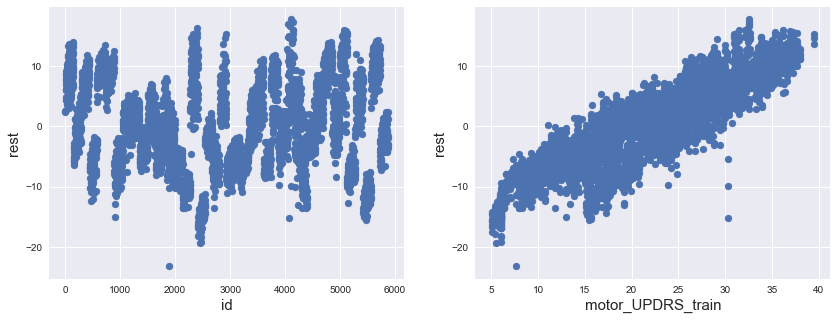

In [355]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(np.array(train_data)[:,-1], np.array(train_data)[:,-3]-pred)
plt.xlabel('id', fontsize=15)
plt.ylabel('rest', fontsize=15)

plt.subplot(1, 2, 2)
plt.scatter(np.array(train_data)[:,-3], np.array(train_data)[:,-3]-pred)
plt.xlabel('motor_UPDRS_train', fontsize=15)
plt.ylabel('rest', fontsize=15)

plt.show()

На первом графике видим небольшую автокоррелированность остатков. На втором же графике видим очень большую разницу в дисперсии (гетероскедестичность). Отсюда можем сделать вывод, что либо нам не хватает признаков, либо линейная модель не походит. 

В силу графика зависимости целевых переменных от subject попробуем сделать для разных значений subject разные модели. Кроме того, добавим несколько новых признаков: по графикам зависимостей целевой переменной от остальных можно увидеть явное разделение области значения целевой переменной от области значений признаков HNR, NHR, Jitter(%) (). Поэтому добавим эти границы (границы этих областей)

In [934]:
data['HNR_border'] = np.array(data.HNR) <= 10
data['NHR_border'] = np.array(data.NHR) <= 0.3
data['Jitter_border'] = np.array(data['Jitter(%)']) <= 0.03

ind_test = np.where(data.isnull().values[:,-5])
ind_train = np.where(data.isnull().values[:,-5] == False)
train_data = data.iloc[ind_train]
test_data = data.iloc[ind_test]

Обучаем разные модели в зависимости значения subject

In [936]:
models = {}

subject = np.array(train_data['subject#'])

for s in np.unique(subject):
    X_train_s = np.array(train_data.drop(['subject#', 'motor_UPDRS_train', 'total_UPDRS_train'], axis=1))[subject == s]
    y_train_motor_s = np.array(train_data['motor_UPDRS_train'])[subject == s]
    y_train_total_s = np.array(train_data['total_UPDRS_train'])[subject == s]
    model_motor = LinearRegression()
    model_motor.fit(X_train_s , y_train_motor_s)
    pred_motor = model_motor.predict(X_train_s)
    
    model_total = LinearRegression()
    model_total.fit(X_train_s , y_train_total_s)
    pred_total = model_total.predict(X_train_s)
    
    models[s] = [model_motor, model_total]
    
    

Посмотрим на rmse на обучающей выборке

In [938]:
def predict(X):
    predictions_motor = np.zeros(len(X))
    predictions_total = np.zeros(len(X))
    
    subject = np.array(X['subject#'])
    
    for s in np.unique(subject):
        X_s = np.array(X.drop('subject#', axis=1))[subject==s]
        model_motor = models[s][0]
        model_total = models[s][1]
        
        pred_motor = model_motor.predict(X_s)
        pred_total = model_total.predict(X_s)
        
        predictions_motor[subject==s] = pred_motor
        predictions_total[subject==s] = pred_total
        
    return (predictions_motor, predictions_total)


predictions = predict(train_data.drop(['motor_UPDRS_train', 'total_UPDRS_train'], axis=1))
print('motor_UPDRS_train ', np.sqrt(mean_squared_error(predictions[0], np.array(train_data['motor_UPDRS_train']))))
print('total_UPDRS_train ', np.sqrt(mean_squared_error(predictions[1], np.array(train_data['total_UPDRS_train']))))


motor_UPDRS_train  1.0841398354061227
total_UPDRS_train  1.202106275237435


Посмотрим на остатки

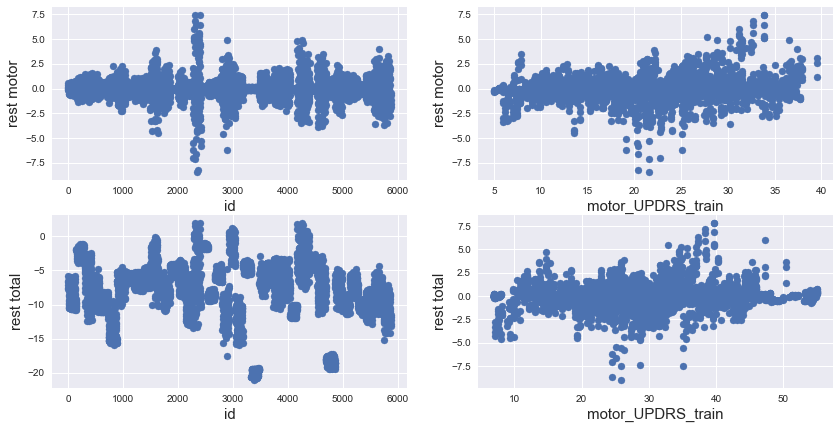

In [941]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 2, 1)
plt.scatter(np.array(train_data['id']), np.array(train_data['motor_UPDRS_train'])-predictions[0])
plt.xlabel('id', fontsize=15)
plt.ylabel('rest motor', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(np.array(train_data['motor_UPDRS_train']), np.array(train_data['motor_UPDRS_train'])-predictions[0])
plt.xlabel('motor_UPDRS_train', fontsize=15)
plt.ylabel('rest motor', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(np.array(train_data['id']), np.array(train_data['motor_UPDRS_train'])-predictions[1])
plt.xlabel('id', fontsize=15)
plt.ylabel('rest total', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(np.array(train_data['total_UPDRS_train']), np.array(train_data['total_UPDRS_train'])-predictions[1])
plt.xlabel('motor_UPDRS_train', fontsize=15)
plt.ylabel('rest total', fontsize=15)

plt.show()

Стало гораздо лучше. Гетероскедестичность связана с тем, что у нас несколько моделей для разных subject. Поэтому внутри одного subject получаются примерно одинаковые дисперсии, а если смотреть в совокупности, то мы видим такие вот полосы.

Отправляем пресказания

In [946]:
X = data.drop(['motor_UPDRS_train', 'total_UPDRS_train'], axis=1)
all_predictions = predict(X)

sample = pd.read_csv('parkinsons_updrs_sample.csv')
sample['motor_UPDRS'] = all_predictions[0]
sample['total_UPDRS'] = all_predictions[1]
sample.to_csv('answers_4.csv', index=False)

## Задача 5

In [1135]:
data = pd.read_csv('hw9t5_train.csv')
data.head()

,id,sex,region,school,PhD,average grades,english,child,experience,alcohol,height,salary_train
0,0,f,Moscow,other,0,3.50,advanced,1,6,173,173,1152216.0
1,1,m,Moscow,2,1,4.76,advanced,0,4,87,170,1010287.0
2,2,m,Krasnodar region,NaN,0,4.22,intermediate,1,6,71,181,1090723.0
3,3,m,Moscow,other,0,3.34,beginner,1,7,254,169,NaN
4,4,m,Bashkortostan,NaN,0,4.31,intermediate,0,4,215,189,878325.0


Немного видоизменим строку school. Заменим NaN на 0 и заменим other на номер еще не встречающейся школы.

In [1136]:
data.school.fillna('0', inplace=True)
np.unique(data.school)

array(['0', '1189', '1534', '1543', '2', '444', '54', '57', 'other'],
      dtype=object)

In [1137]:
school = np.array(data.school)
school[school == 'other'] = '1'
data.school = school

Заметим, что у нас есть категориальные признаки - sex, region, school, english. Закодируем их используя OneHotEncoder

In [1138]:
int_enc = LabelEncoder()
data.iloc[:,1] = int_enc.fit_transform(data.iloc[:,1])
data.iloc[:,2] = int_enc.fit_transform(data.iloc[:,2])
data.iloc[:,3] = int_enc.fit_transform(data.iloc[:,3])
data.iloc[:,6] = int_enc.fit_transform(data.iloc[:,6])
           
bin_enc = OneHotEncoder()
categorical = np.array(bin_enc.fit_transform(data.iloc[:,[1, 2, 3, 6]]).toarray())
new_data = np.hstack((np.array(data.iloc[:,[0, 4, 5, 7, 8, 9, 10]]), categorical))
targets = np.array(data.salary_train)

Разделим выборку на обучение и тест

In [1139]:
ind_test = np.where(np.isnan(targets))
ind_train = np.where(np.isnan(targets)== False)
train_data = new_data[ind_train]
test_data = new_data[ind_test]
train_data = np.array(train_data)
y_train = np.array(targets[ind_train], dtype=int)

Посмотрим на линейную регрессию на всех признаках

In [1118]:
model = LinearRegression()
model.fit(train_data, y_train)
pred = model.predict(train_data)
print('rmse train ', np.sqrt(mean_squared_error(pred, y_train)))

rmse train  357550.90630125854


Очень много( Посмотрим на остатки

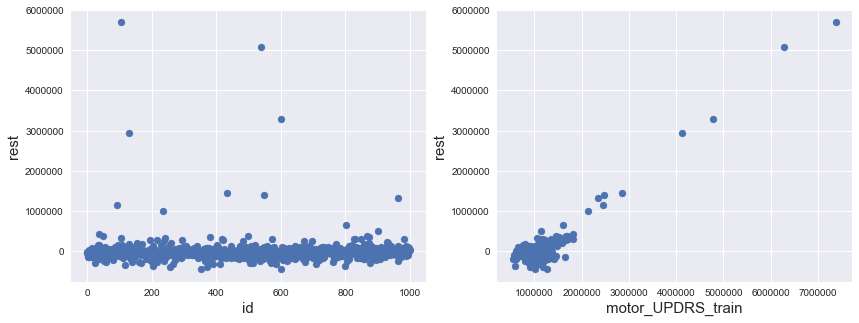

In [1119]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(train_data[:,0], y_train-pred)
plt.xlabel('id', fontsize=15)
plt.ylabel('rest', fontsize=15)

plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train-pred)
plt.xlabel('motor_UPDRS_train', fontsize=15)
plt.ylabel('rest', fontsize=15)

plt.show()

Кажется, что в нашей модели есть выбросы. Посмотрим на графики зависимостей целевой переменной от остальных

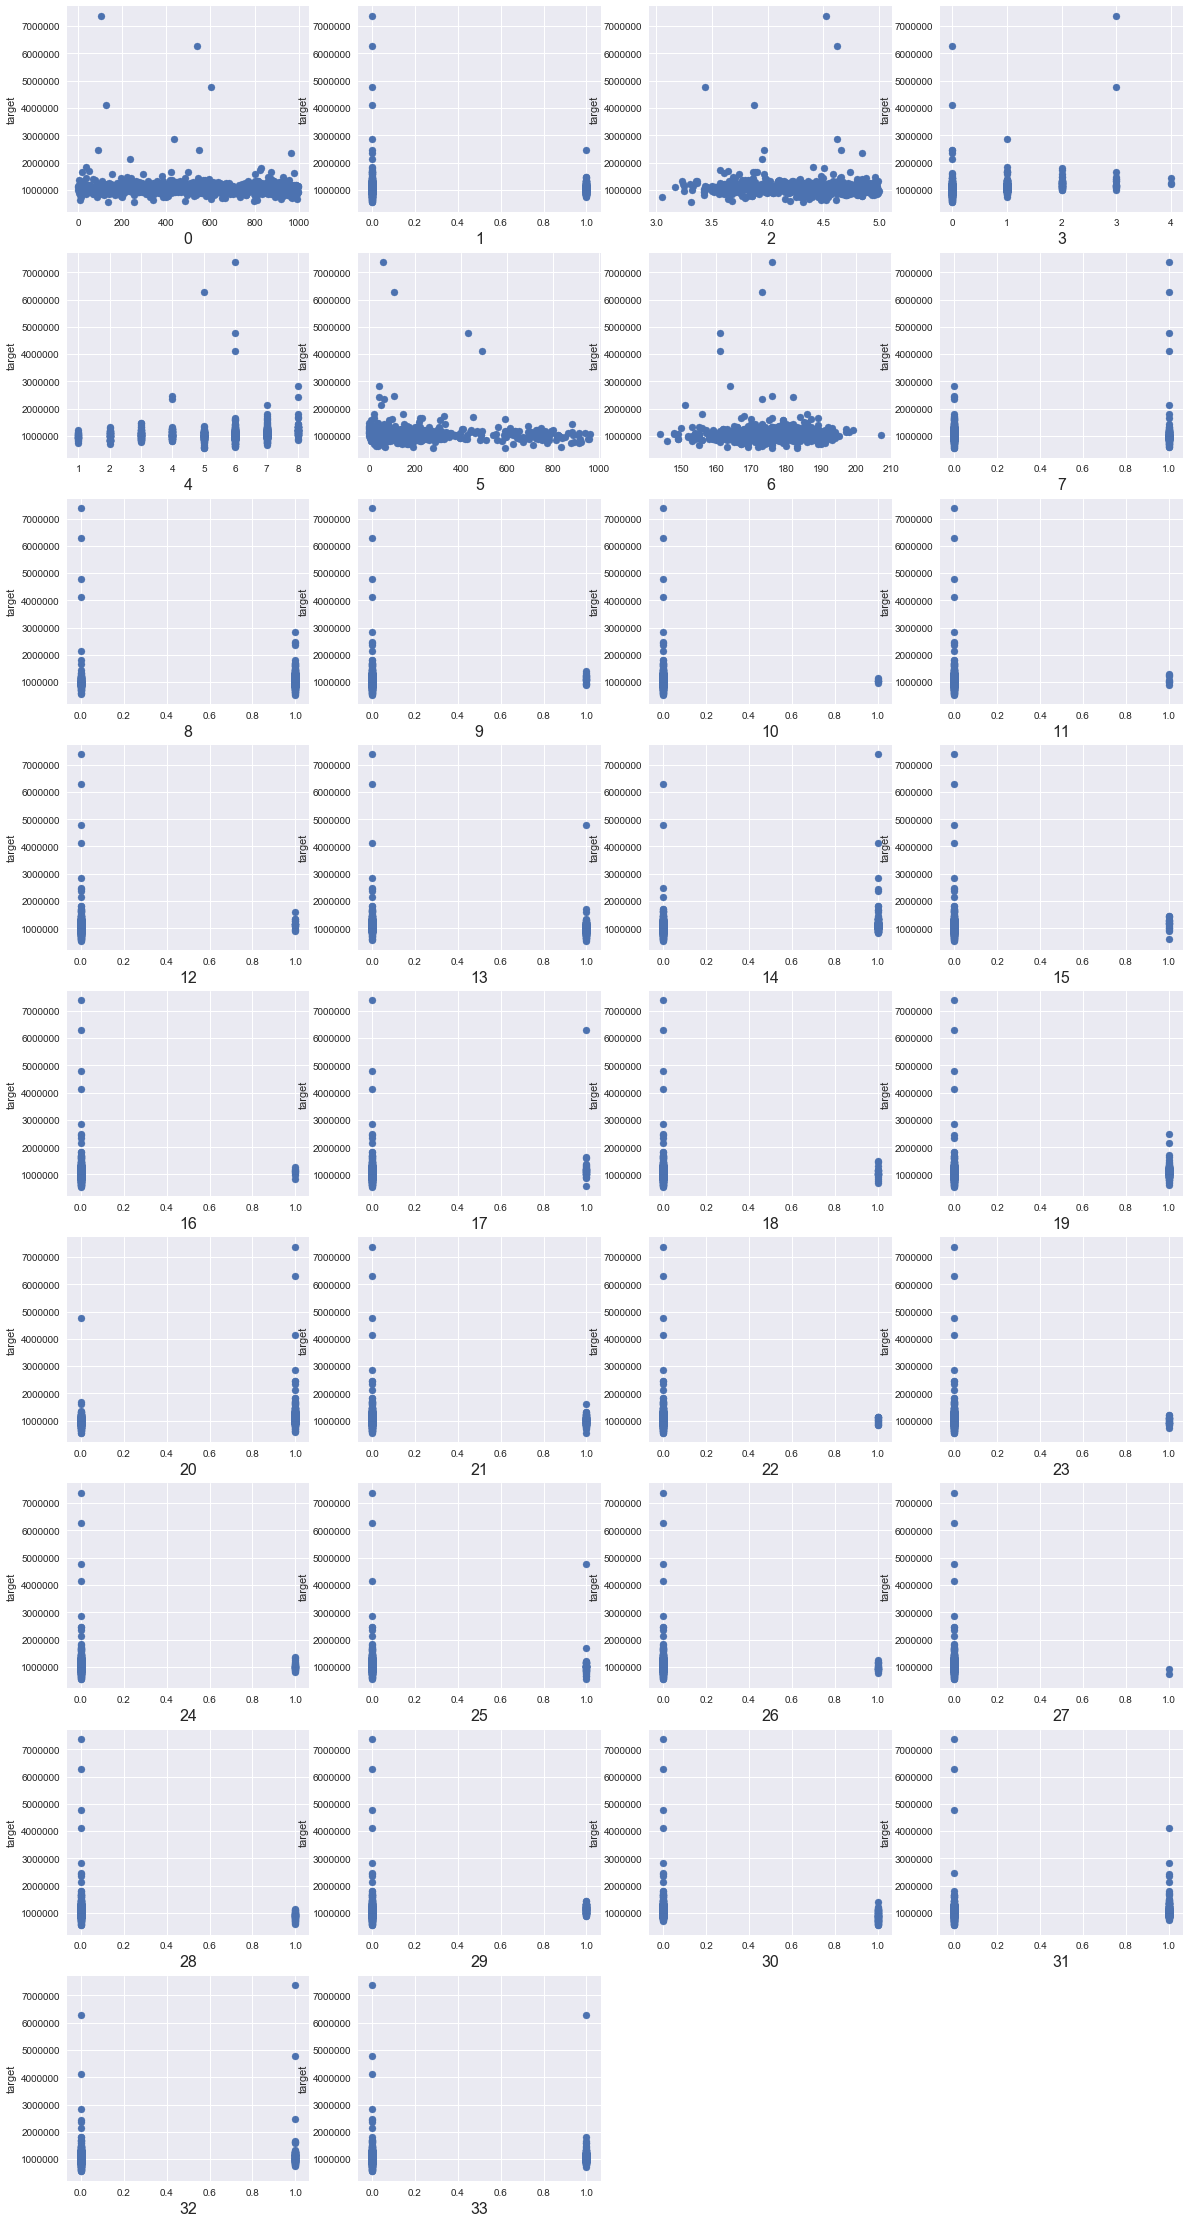

In [1120]:
plt.figure(figsize=(20, 40))
for i in range(train_data.shape[1]):
    plt.subplot(9, 4, i+1)
    plt.scatter(train_data[:,i], y_train)
    plt.xlabel(str(i), fontsize=16)
    plt.ylabel('target',fontsize=11)
plt.show()

На этих графиках тоже видны выбросы. Чтобы выбросы не так сильно влияли на нашу модель модель воспользуемся робастной регрессией. 

In [966]:
def Huber(x, k=1.345):
    if abs(x) <= k:
        return x**2 / 2
    else:
        return k * (abs(x) - k/2)

def Cauchy(x, c=2.3849):
    return (c**2 / 2) * np.log(1 + (x / c)**2)

def L1(x):
    return abs(x)

In [795]:
def find_min(X, Y, ro):
    def func_to_min(beta):
        f = 0
        for i, x in enumerate(X):
            f += ro(Y[i] - np.sum(x * beta))
        return f
    
    initial_beta = np.array([1 / X.shape[1]] * X.shape[1])
    res = optimize.minimize(func_to_min, initial_beta)
    return res

In [781]:
from scipy import optimize
find_min(train_data, y_train, Huber)

      fun: 99631886.67456156
 hess_inv: array([[6.87330696e-04, 3.30523114e-01, 3.00644794e-01, ...,
        4.37704605e-02, 5.54773072e-03, 4.81782595e-02],
       [3.30523114e-01, 5.00859398e+02, 4.62544323e+02, ...,
        6.88877256e+01, 8.84521642e+00, 5.78435645e+01],
       [3.00644794e-01, 4.62544323e+02, 4.29531340e+02, ...,
        6.38744535e+01, 8.11051295e+00, 5.24148762e+01],
       ...,
       [4.37704605e-02, 6.88877256e+01, 6.38744535e+01, ...,
        1.05396507e+01, 1.21939621e+00, 7.80406988e+00],
       [5.54773072e-03, 8.84521642e+00, 8.11051295e+00, ...,
        1.21939621e+00, 1.17277940e+00, 1.24469980e+00],
       [4.81782595e-02, 5.78435645e+01, 5.24148762e+01, ...,
        7.80406988e+00, 1.24469980e+00, 1.03357907e+01]])
      jac: array([ 9.293e+03,  1.900e+01,  1.050e+02,  0.000e+00,  1.020e+02,
        1.857e+03,  2.841e+03, -6.000e+00,  4.400e+01, -1.000e+00,
       -4.000e+00,  4.000e+00,  3.000e+00,  2.000e+00, -1.600e+01,
       -2.000e+00,  8.000e+

In [827]:
find_min(train_data, y_train, L1)

      fun: 67369393.33340295
 hess_inv: array([[ 1.57964773e-05, -1.60928208e-02,  5.61225052e-05, ...,
         3.45355443e-03, -1.87363243e-03, -2.60394130e-03],
       [-1.60928208e-02,  5.82257837e+01, -3.87912985e-01, ...,
        -8.26323217e+00, -2.91657773e-02, -5.99758998e+00],
       [ 5.61225052e-05, -3.87912985e-01,  1.36769101e-01, ...,
         7.61312907e-02,  2.10676443e-01, -4.56757333e-01],
       ...,
       [ 3.45355443e-03, -8.26323217e+00,  7.61312907e-02, ...,
         5.02191114e+00, -1.70014230e+00,  2.73282720e+00],
       [-1.87363243e-03, -2.91657773e-02,  2.10676443e-01, ...,
        -1.70014230e+00,  8.96761180e+00, -2.82861626e+00],
       [-2.60394130e-03, -5.99758998e+00, -4.56757333e-01, ...,
         2.73282720e+00, -2.82861626e+00,  1.38352858e+01]])
      jac: array([-1.475e+03, -3.000e+00, -1.800e+01,  0.000e+00, -6.000e+00,
       -1.383e+03, -6.200e+02, -2.000e+00, -2.000e+00,  2.000e+00,
       -1.000e+00,  0.000e+00, -2.000e+00, -1.000e+00, -2.

Посмотрим на веса обьектов и определим выбросы. 

In [1044]:
huber_weights = np.ones(new_train.shape[0])
diff = y_train - np.dot(new_train, beta)
k = 1.345
huber_weights[np.abs(diff) >= k] = k / np.abs(diff)[np.abs(diff) >= k]
outliers = np.argsort(huber_weights)[-7:]
non_outliers = np.argsort(huber_weights)[:-7]
print('Функция Хьюбера: выбросы ', outliers)

Функция Хьюбера: выбросы  [240 130 229 396 249 327 505]


In [1121]:
outliers = np.argsort(1 / diff)[-7:]
non_outliers = np.argsort(1 / diff)[:-6]
print('L1: выбросы ', outliers)

L1: выбросы  [621 482 240 396 249 327 505]


Посмотрим, что получается

In [1122]:
model = LinearRegression()
model.fit(train_data[non_outliers], y_train[non_outliers])
pred = model.predict(train_data)
print('rmse train ', np.sqrt(mean_squared_error(pred, y_train)))

rmse train  357552.65098539816


Теперь выберем признаки с помощью пошаговой регрессии

In [1140]:

def dict_max_key(d):
    return np.array(list(d.keys()))[np.argmax(list(d.values()))]

def dict_min_key(d):
    return np.array(list(d.keys()))[np.argmin(list(d.values()))]

def RSS(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def calc_student_intervals(X, y, alpha=0.05):
    k = X.shape[1]
    n = X.shape[0]
    
    X = np.matrix(X)
    
    Z = np.linalg.inv(X.T * X)
    beta = np.array(Z * X.T * np.matrix(y).T).reshape(-1)
    return list(zip(beta - sps.t.ppf(1.0 - alpha / 2.0, n - k - 1) * np.sqrt(np.diag(Z)),
               beta + sps.t.ppf(1.0 - alpha / 2.0, n - k - 1) * np.sqrt(np.diag(Z))))

def stepwise_regression_selection(X, y, p_in=0.05, p_out=0.1):
    n = X.shape[0]
    k = X.shape[1]
    
    def calc_pred(features):
        reg = LinearRegression()
        reg.fit(X[:, features], y)
        return reg.predict(X[:, features])
        
    #initialize 
    feature_scores = dict()
    for feature in range(k):
        y_pred = calc_pred([feature])
        
        left, right = calc_student_intervals(X[:, [feature]], y)[0]
        feature_scores[feature] = np.abs((left + right) / (right - left))
        
    current_features = [dict_max_key(feature_scores)]
    cur_rss = RSS(y, calc_pred(current_features))

    while True:
        features_backup = copy.deepcopy(current_features)
        
        # add
        feature_scores = dict()
        for feature in set(range(k)) - set(current_features):
            y_pred = calc_pred(current_features + [feature])
            
            new_rss = RSS(y, y_pred)
            feature_scores[feature] = 1.0 - sps.f.cdf((cur_rss - new_rss) * (n - len(current_features) - 2.0) / new_rss, 
                                                  n - len(current_features) - 2.0, 1)
            
        candidate_feature = dict_min_key(feature_scores)
        if feature_scores[candidate_feature] < p_in:
            current_features.append(candidate_feature)
            cur_rss = RSS(y, calc_pred(current_features))
            
        # remove
        if len(current_features) == 1:
            break
        feature_scores = dict()
        for feature in current_features:
            new_features = copy.deepcopy(current_features)
            new_features.remove(feature)
            y_pred = calc_pred(new_features)
            
            new_rss = RSS(y, y_pred)
            feature_scores[feature] = 1.0 - sps.f.cdf((new_rss - cur_rss) * (n - len(current_features) - 1.0) / cur_rss, 
                                                   n - len(current_features) - 1.0, 1)
            
        candidate_feature = dict_max_key(feature_scores)
        if feature_scores[candidate_feature] > p_out:
            current_features.remove(candidate_feature)
            cur_rss = RSS(y, calc_pred(current_features))
               
        if set(features_backup) == set(current_features):
            break
            

    return current_features

In [1168]:
important_features = stepwise_regression_selection(np.array(train_data[non_outliers], dtype=float), y_train[non_outliers], p_in=0.8, p_out=0.8)
important_features

[3, 13, 30, 4, 17, 14, 28, 33, 25, 0, 31, 19]

In [1169]:
model = LinearRegression()
model.fit(train_data[non_outliers][:,important_features], y_train[non_outliers])
pred = model.predict(train_data[:,important_features])
print('rmse train ', np.sqrt(mean_squared_error(pred, y_train)))

rmse train  357983.27082938084


Хм, пошаговая регрессия не помогла( 

Попробуем лассо 

In [1175]:
model = Lasso(alpha=0.001)
model.fit(train_data[non_outliers], y_train[non_outliers])
pred = model.predict(train_data)
print('rmse train ', np.sqrt(mean_squared_error(pred, y_train)))

rmse train  357552.65098807483


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Стало чуть лучше.
Сохраняем предсказания

In [1176]:
sample = pd.read_csv('hw9t5_sample.csv')
all_predictions = model.predict(new_data)
sample['salary'] = all_predictions
sample.to_csv('answers_5.csv', index=False)

Также можно было построить несколько лин. регрессий в зависимости от школы. Но я уже не успела(